In [4]:
import os
import sys

module_path = os.path.abspath(os.path.join('../ipsim'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ipsim import *

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from copy import deepcopy

In [5]:
class ECSRTTest:
    Ea  = 72750     # activation energy J/gmol
    R   = 8.314     # gas constant J/gmol/K
    k0  = 7.2e10    # Arrhenius rate constant 1/min
    dHr = -5.0e4    # Enthalpy of reaction [J/mol]
    rho = 1000.0    # Density [g/L]
    Cp  = 0.239     # Heat capacity [J/g/K]
    UA  = 5.0e4     # Heat transfer [J/min/K]
    
    V   = 100.0     # Volume [L]
    q   = 100.0     # Flowrate [L/min]
    cAi = 1.0       # Inlet feed concentration [mol/L]
    Ti  = 350.0     # Inlet feed temperature [K]
    Tc  = 305.0     # Coolant temperature [K]

    cA0 = 0.5;      # Initial concentration [mol/L]
    T0  = 350.0;    # Initial temperature [K]
    
    def k(T):
        return ECSRTTest.k0*np.exp(-ECSRTTest.Ea/ECSRTTest.R/T)


In [6]:
class ExothermicContinuousStirredTankReactor0(ProcessNode):
    def __init__(self, name, *, cA0 = ECSRTTest.cA0, T0 = ECSRTTest.T0, V = ECSRTTest.V
                , dHr = ECSRTTest.dHr, rho = ECSRTTest.rho, Cp=ECSRTTest.Cp,UA = ECSRTTest.UA):
        super().__init__(name)
        self._cA = deepcopy(cA0)
        self._T = deepcopy(T0)
        self._cB = 0
        self._V = V
        self._dHr = dHr
        self._rho=rho
        self._Cp = Cp
        self._UA = UA
        self.create_input("q")
        self.create_input("cAi")
        self.create_input("Ti")
        self.create_input("Tc")
        self.create_output("cA")
        self.create_output("T")
        self.create_output("cB")
        self._calltimes = 0
    
    def __call__(self, t, y):
        i = self.inputs()
        q   = i["q"]()
        cAf = i["cAi"]()
        Tf  = i["Ti"]()
        Tc  = i["Tc"]()

        cA, T, cB = y
       
        qV    = q/self._V
        kCa = ECSRTTest.k(T)*cA
        dHpC  = -self._dHr/(self._rho*self._Cp)
        UAVpC = self._UA/(self._V*self._rho*self._Cp)

        dcAdt = qV*(cAf - cA) - kCa
        dTdt  = qV*(Tf - T) + dHpC*kCa + UAVpC*(Tc-T)
        dBdt  = qV*(0 - cB) + kCa

        return [dcAdt, dTdt, dBdt]
        
    def evaluate(self):
        self._calltimes = self._calltimes+1
        
        i = self.inputs()
        q   = i["q"]()
        cAf = i["cAi"]()
        Tf  = i["Ti"]()
        Tc  = i["Tc"]()
        cA  = self._cA
        T   = self._T
        cB  = self._cB
        
        dt = self._model.dt()

        t_eval = np.linspace(0, dt, 10)
        soln = solve_ivp(self, [min(t_eval), max(t_eval)], [cA, T, cB], t_eval=t_eval)
        
        cA = soln.y[0, :][-1]
        T  = soln.y[1, :][-1]
        cB = soln.y[2, :][-1]
        
        self._cA = cA
        self._T = T
        self._cB = cB
        
        self.set_result("cA",cA)
        self.set_result("cB",cB)
        self.set_result("T",T)

In [7]:
def prepare_model(dt = 10.0/2000):    
    process_model = ProcessModel("test",dt=dt)
    process_model.add_node(ProcessInputNode("InletFeed"
                                         , {"Flowrate":100,"Concentration":1,"Temperature":350}))
    process_model.add_node(ProcessInputNode("Coolant"
                                          , {"Temperature":290}))
    process_model.add_node(ExothermicContinuousStirredTankReactor0("ECSTR"))
    process_model.bond_nodes("ECSTR","q","InletFeed","Flowrate")
    process_model.bond_nodes("ECSTR","cAi","InletFeed","Concentration")
    process_model.bond_nodes("ECSTR","Ti","InletFeed","Temperature")
    process_model.bond_nodes("ECSTR","Tc","Coolant","Temperature")
    
    return process_model

In [8]:
def run_model_clean(process_model, iterations): 
    parameters_metadata = (
          {"parameter":"cA", "range":(0,1), "units": "", "title":"Concentration of A"}
        , {"parameter":"cB", "range":(0,1), "units": "", "title":"Concentration of B"}
        , {"parameter":"T", "range":(300,600),"units": "K", "title":"Temperature" }
    )
    x = np.empty((iterations,len(parameters_metadata)))
    for _ in range(iterations):
        state = process_model.next_state(("ECSTR",))
        data =  []
        for metadata in parameters_metadata:
             data.append(state['ECSTR'][metadata["parameter"]])

        x[_] =  data

    return x, parameters_metadata

In [9]:
def show_data(x, metadata, dt, title = "", *, cols=3):
    fig = plt.figure(figsize=(6,6),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                plt.plot([i/int(1/dt) for i in range(len(x))] ,x[:,index])
                plt.title(metadata[index]["title"])
    
    plt.tight_layout()
    plt.show()

In [10]:
def show_unined_data(xa, metadata, dt, legends = (), title = "", *, cols=3):
    fig = plt.figure(figsize=(12,3),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    #fmts = ("-k", "--r",  "-.g", ":k", ":m", "-b")
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                ax = plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                for xi in range(len(xa)):
                    x = xa[xi]
                    #fmt = fmts[xi]
                    plt.plot([i/int(1/dt) for i in range(len(x))] ,x[:,index])#, fmt)
                plt.xlabel('min')
                plt.ylabel(metadata[index]["units"])
                plt.title(metadata[index]["title"])
    
    plt.tight_layout()
    fig.legend(legends,loc='outside right upper')
    plt.tight_layout()
    plt.show()

In [11]:
def run_0():
    iterations = 2000
    target_time = 10
    dt = target_time/iterations
    process_model = prepare_model(dt)
    process_model.nodes()["Coolant"].change_value("Temperature",305)
    x, metadata = run_model_clean(process_model,iterations)
    show_data(x, metadata, dt)

In [12]:
def run_1():
    iterations = 1000
    target_time = 10
    dt = target_time/iterations

    xa = []
    ma = []
    la = []
    for Tc in range(290,310,1):
        process_model = prepare_model(dt)
        process_model.nodes()["Coolant"].change_value("Temperature",Tc)
        x, metadata = run_model_clean(process_model,iterations)
        xa.append(x)
        ma.append(metadata)
        la.append(f"Coolant T {Tc}")
        
    show_unined_data(xa, metadata, dt, la)

In [13]:
def run_model_steps(process_model, Tcs, iterations_per_step): 
    parameters_metadata = (
          {"parameter":"cA", "range":(0,1), "units": "", "title":"Concentration of A"}
        , {"parameter":"cB", "range":(0,1), "units": "", "title":"Concentration of B"}
        , {"parameter":"T", "range":(300,600),"units": "K", "title":"Temperature" }
    )

    iterations = int(len(Tcs)*iterations_per_step)
    x = np.empty((iterations,len(parameters_metadata)))
    y = np.empty((iterations,1),dtype=np.dtype('B'))

    Tci = -1
    Tc  = 0
    for _ in range(iterations):
        if _ % iterations_per_step == 0:
            Tci = 0 if Tci == -1 else Tci + 1
            Tc = Tcs[Tci]                 
            process_model.nodes()["Coolant"].change_value("Temperature", Tc)
        state = process_model.next_state(("ECSTR",))
        data =  []
        for metadata in parameters_metadata:
             data.append(state['ECSTR'][metadata["parameter"]])

        x[_] =  data
        y[_] = 0 if (Tc < 304 or Tc > 308) else 1

    return x, parameters_metadata, y

In [14]:
def train_logistic(x,y):
    model = LogisticRegression()
    model.fit(x, y.ravel())
    return model

def train_random_forest(x,y):
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(x, y.ravel())
    return model

def train_gradient_boostins(x,y):
    model = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0)
    model.fit(x, y.ravel())
    return model

def train_ada_boostins(x,y):
    model = AdaBoostClassifier(n_estimators=500, algorithm="SAMME", random_state=0)
    model.fit(x, y.ravel())
    return model

def train_bagging(x,y):
    model = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0)
    model.fit(x, y.ravel())
    return model

In [15]:
def show_model_statistics(y, y_pred, model_name):
    f_metrics = {"Accuracy":accuracy_score
                ,"Precision":precision_score
                ,"Recall":recall_score
                ,"F1" : f1_score
                ,"Cohens kappa": cohen_kappa_score
                ,"ROC AUC": roc_auc_score
                ,"Confusion matrix": confusion_matrix}
    print(f"{model_name}:")
    for metric in f_metrics:
        try:
            print(metric, f_metrics[metric](y, y_pred))
        except Exception as e:
            print(f"Metiric {metric}: {e}")

In [25]:
def run_2():
    dt = 0.1
    process_model = prepare_model(dt)
    x, metadata, y = run_model_steps(process_model,[295, 300, 304, 305, 306, 312], 500)
    #show_data(x, metadata, dt)
    count_true = 0
    for yi in y:
        if yi == 0:
            count_true += 1
    print(f"normal class: {count_true} faults: {len(y)-count_true} total: {len(y)}")

    models = {#"ff_nn": train_ff_nn
              "logistic":train_logistic
             ,"random_forest":train_random_forest
             ,"gradient_boostins":train_gradient_boostins
             ,"ada_boostins": train_ada_boostins
             ,"bagging":train_bagging
             }
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

    for title, func in models.items():
        ml_model = func(x_train,y_train)
        y_pred   = ml_model.predict(x_test)
        show_model_statistics(y_test,y_pred, title)

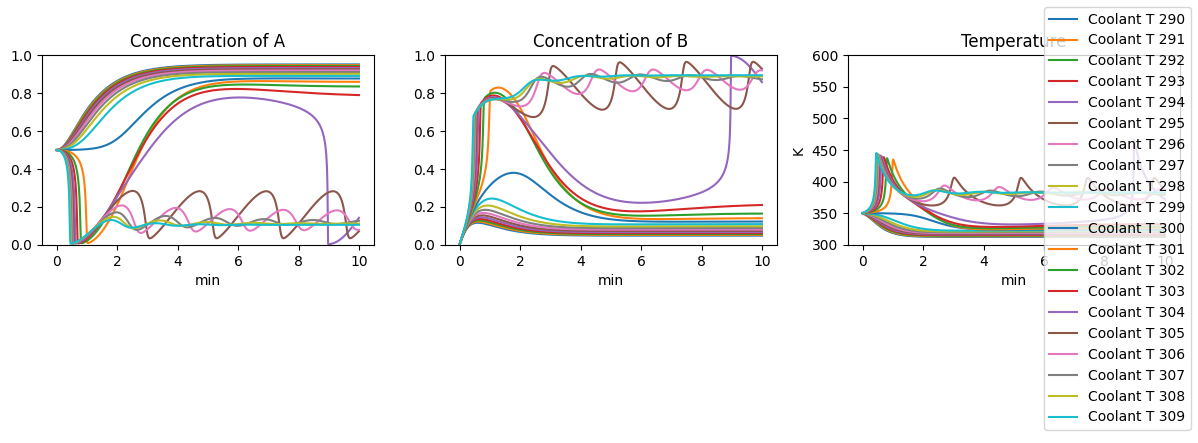

In [17]:
run_1()

In [26]:
run_2()

normal class: 1500 faults: 1500 total: 3000
logistic:
Accuracy 0.7066666666666667
Precision 0.685857321652065
Recall 0.7435549525101763
F1 0.7135416666666666
Cohens kappa 0.41399694923260233
ROC AUC 0.7072951695709466
Confusion matrix [[512 251]
 [189 548]]
random_forest:
Accuracy 0.9193333333333333
Precision 0.9797507788161994
Recall 0.8534599728629579
F1 0.9122552574329225
Cohens kappa 0.8382629710423884
ROC AUC 0.918210982499631
Confusion matrix [[750  13]
 [108 629]]
gradient_boostins:
Accuracy 0.984
Precision 0.9890260631001372
Recall 0.9782903663500678
F1 0.9836289222373806
Cohens kappa 0.9679844617921232
ROC AUC 0.9839027192169737
Confusion matrix [[755   8]
 [ 16 721]]
ada_boostins:
Accuracy 0.9846666666666667
Precision 0.9863760217983651
Recall 0.9823609226594301
F1 0.9843643779741672
Cohens kappa 0.9693219892867051
ROC AUC 0.9846273813821397
Confusion matrix [[753  10]
 [ 13 724]]
bagging:
Accuracy 0.7153333333333334
Precision 0.6904176904176904
Recall 0.762550881953867
F1 0.